In [25]:
import numpy as np
import matplotlib.pyplot as plt
import crispr_assembler as ca

In [2]:
from tqdm import tqdm_notebook

In [3]:
import sys
sys.path.append("../utils/")

In [4]:
import plot_utils as pu

In [5]:
class PCR:
    def __init__(self, population_as_list, n_primers, p = None, transform_to_min_range = 1):
        if transform_to_min_range:
            population_as_list = self._transform_to_min_range(population_as_list)
            
        self.max_array_len = max([len(x) for x in population_as_list])
        
        self.f_population = np.ones((len(population_as_list), self.max_array_len + 2)) * -1
        
        for i, array in enumerate(population_as_list):
            self.f_population[i][1:1 + len(array)] = np.array(array) + 1
        self.b_population = np.copy(self.f_population)
        
        self.n_f_primes = n_primers
        self.n_b_primers = n_primers
        self.initial_n_f = n_primers
        self.initial_n_b = n_primers
        
        self.n_spacers = len(set([x for y in population_as_list for x in y]))
        
        if p is None:
            self.p = [1 / self.max_array_len, 0.1 / self.max_array_len, 0]
            self.p[-1] = 1 - self.p[0] - self.p[1]

            self.initial_p = [x for x in self.p]
        else:
            self.p = [x for x in p]
            self.initial_p = [x for x in p]
        
        self.correct_pairs = set(self.to_pairs().keys())
        
    def _transform_to_min_range(self, population_as_list):
        spacers = set([sp for arr in population_as_list for sp in arr])
        spacers_list_sorted = sorted(list(spacers))
        translate_dict = dict(zip(spacers_list_sorted, np.arange(len(spacers)).astype(int)))
        population_transformed = [[translate_dict[sp] for sp in arr] for arr in population_as_list]
        
        return population_transformed
        
    def _increase_populations(self, n_f, n_b):
        self.f_population = np.vstack((self.f_population, np.zeros((n_f, self.max_array_len + 2))))
        self.b_population = np.vstack((self.b_population, np.zeros((n_b, self.max_array_len + 2))))
        
        self.n_f_primes -= n_f
        self.n_b_primers -= n_b
        
    def _make_annealing_masks(self, f_mask=None, b_mask=None):
        #print(self.b_population.size)
        if f_mask is None or b_mask is None:
            f_annealing_mask = np.random.choice([0,1,2], self.f_population.shape, p = self.p)#.reshape(self.f_population.shape)
            b_annealing_mask = np.random.choice([0,1,2], self.b_population.shape, p = self.p)#.reshape(self.b_population.shape)
        else:
            f_annealing_mask = f_mask
            b_annealing_mask = b_mask

        
        f_annealing_mask[self.f_population <= 0] = 2
        b_annealing_mask[self.b_population <= 0] = 2
        return f_annealing_mask, b_annealing_mask, (b_annealing_mask == 0).sum(), (f_annealing_mask == 0).sum()
    
        
    def _make_annealing_linkage(self, f_annealing_mask, b_annealing_mask):
        f_indeces_0 = np.vstack(np.where(f_annealing_mask == 0)).T
        nonzero_b = (self.b_population.sum(1) != 0).sum()
        b_paired_0 = np.vstack((np.arange(nonzero_b,
                                          nonzero_b + f_indeces_0.shape[0]),
                                np.ones(f_indeces_0.shape[0]) * (self.max_array_len + 2))).T
        
        #print(self.f_population.shape)
        b_indeces_0 = np.vstack(np.where(b_annealing_mask == 0)).T
        nonzero_f = (self.f_population.sum(1) != 0).sum()
        f_paired_0 = np.vstack((np.arange(nonzero_f,
                                          nonzero_f + b_indeces_0.shape[0]),
                                -np.ones(b_indeces_0.shape[0]))).T
        
        
        f_indeces_1 = np.vstack(np.where(f_annealing_mask == 1)).T
        b_indeces_1 = np.vstack(np.where(b_annealing_mask == 1)).T
        np.random.shuffle(f_indeces_1)
        np.random.shuffle(b_indeces_1)
        f_indeces_1 = f_indeces_1[:min(f_indeces_1.shape[0], b_indeces_1.shape[0])]
        b_indeces_1 = b_indeces_1[:min(f_indeces_1.shape[0], b_indeces_1.shape[0])]
        

        return np.vstack((f_indeces_0, f_paired_0, f_indeces_1)).astype(int), \
                np.vstack((b_paired_0, b_indeces_0, b_indeces_1)).astype(int)

    def _debug_set_populations(self, fp, bp):
        self.f_population = fp
        self.b_population = bp 
        
        
    def _copy(self, index_f, index_b):
        if index_f[1] <= self.max_array_len and self.f_population[index_f[0], index_f[1] + 1] == 0:
            b_copy_part = self.b_population[index_b[0], index_b[1]:]
#             print(b_copy_part)
            copy_len = min(b_copy_part.shape[0], self.max_array_len + 1 - index_f[1])
            b_copy_part = b_copy_part[:copy_len]
            self.f_population[index_f[0], index_f[1] + 1 :index_f[1] + 1 + copy_len] = b_copy_part

        if index_b[1] > 0 and self.b_population[index_b[0], index_b[1] - 1] == 0:
            f_copy_part = self.f_population[index_f[0], : index_f[1] + 1]
#             print(f_copy_part)
            copy_len = min(f_copy_part.shape[0], index_b[1])
            
            f_copy_part = f_copy_part[-copy_len:]
#             print(f_copy_part, index_b[1] - copy_len, index_b[1])
            self.b_population[index_b[0], index_b[1] - copy_len : index_b[1]] = f_copy_part
    
    
    def _recalc_p(self):
        multiplicator = ((self.n_f_primes + self.n_b_primers) / (self.initial_n_f + self.initial_n_b))  ** 0.1
        self.p = [self.initial_p[0] * multiplicator, self.initial_p[1] / multiplicator, 0]
#         print("selfp", self.n_f_primes, self.p[0], multiplicator, multiplicator ** 0.1)
#         if self.p[0] < 0.01:
#             self.p[0] = self.initial_p[1]
#             self.p[1] = self.initial_p[0]
        self.p[2] = 1 - self.p[0] - self.p[1]
        
        
    def anneal(self):
        if self.n_f_primes > 0 and self.n_b_primers > 0:
            self._recalc_p()
            fm, bm, nf,nb = self._make_annealing_masks()
            self._increase_populations(nf, nb)

            fi, bi = self._make_annealing_linkage(fm, bm)

            for i in range(len(fi)):
                self._copy(fi[i], bi[i])
                
            
        if (self.f_population.shape[0] > 100000) or (self.b_population.shape[0] > 100000): 
            f_mask = np.random.binomial(1, 0.5, self.f_population.shape[0]).astype(bool)
            b_mask = np.random.binomial(1, 0.5, self.b_population.shape[0]).astype(bool)
            
            self.f_population = self.f_population[f_mask]
            self.b_population = self.b_population[b_mask]
            
            self.n_f_primes /= 2
            self.n_b_primers /= 2
            self.initial_n_f /= 2
            self.initial_n_b /= 2
            
#             print('ENTER population cut', self.f_population.shape[0], self.b_population.shape[0])
#         else:
#             print('NO population cut', self.f_population.shape[0], self.b_population.shape[0])
        

    def to_pairs(self):
        all_pairs = {}
        for product in np.vstack((self.f_population,self.b_population)):
            for a,b in zip(product, product[1:]):
                if a!= -1 and a!= 0 and b!= -1 and b!=0:
                    if (a,b) in all_pairs:
                        all_pairs[(a,b)] += 1
                    else:
                        all_pairs[(a,b)] = 1
        return all_pairs
    
    def to_graph(self):
        gr = np.zeros((self.n_spacers, self.n_spacers))
        
        for p, n in self.to_pairs().items():
            if p[0] >= 0 and p[1] >= 0:
                gr[int(p[0]) - 1][int(p[1]) - 1] = n
        return gr

In [27]:
p_list_0 = [[1, 3, 6, 8, 9, 10, 13, 14, 15, 17, 12, 16] for i in range(50)] + \
            [[4, 2, 5, 7, 11] for i in range(50)] + \
               [[4, 24, 19, 18, 25, 30, 27, 26, 28, 31, 32, 33, 34] for i in range(10)] + \
               [[1, 20, 22, 23, 21, 29] for i in range(10)]

In [18]:
p_list_0 = [[2, 21, 18, 19, 22, 30, 27, 29, 28, 31, 33, 32, 34] for i in range(10)] + \
           [[0, 20, 24, 26, 23, 25] for i in range(10)] +\
           [[0, 1, 3, 6, 7, 10, 12, 15, 16, 14, 17, 13, 11] for i in range(50)] +\
           [[2, 4, 5, 9, 8] for i in range(50)]

In [19]:
p_list_no0 = [[x+1 for x in y] for y in p_list_0]

In [28]:
pcr = PCR(p_list_0, len(p_list_0) * 100000, p = [0.1, 0.05, 0.85])

In [29]:
gr0 = pcr.to_graph()

In [30]:
for i in range(15):
    pcr.anneal()
    print(pcr.f_population.shape[0], pcr.b_population.shape[0])
    print(pcr.p)
    print('11 sum', pcr.to_graph()[11].sum())

237 233
[0.1, 0.05, 0.85]
11 sum 164.0
394 399
[0.09999990416625339, 0.050000047916919234, 0.8500000479168274]
11 sum 236.0
636 656
[0.09999976958094417, 0.05000011520979339, 0.8500001152092624]
11 sum 317.0
992 1026
[0.0999995616580203, 0.05000021917195058, 0.8500002191700291]
11 sum 431.0
1486 1523
[0.09999925914196799, 0.05000037043176039, 0.8500003704262716]
11 sum 568.0
2242 2306
[0.09999884619009436, 0.050000576911609286, 0.8500005768982963]
11 sum 751.0
3296 3400
[0.09999820485499239, 0.050000897588616824, 0.8500008975563909]
11 sum 994.0
4754 4995
[0.09999730967432002, 0.05000134519903023, 0.8500013451266497]
11 sum 1318.0
6873 7146
[0.09999603721007466, 0.0500019814734843, 0.850001981316441]
11 sum 1782.0
9948 10182
[0.09999425726617261, 0.05000287153181812, 0.8500028712020092]
11 sum 2380.0
14222 14526
[0.09999170940765725, 0.050004145639869484, 0.8500041449524733]
11 sum 3242.0
20292 20521
[0.09998811531261992, 0.050005943050002964, 0.8500059416373772]
11 sum 4425.0
28780 29

In [31]:
gr = pcr.to_graph()

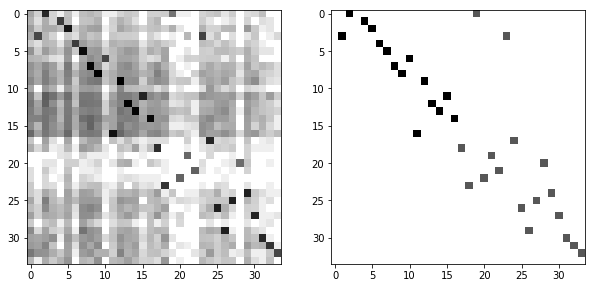

In [33]:
ca.plot_grs(gr, gr0, log = 1)

In [34]:
def calc_noise_ratio(gr0, gr):
    return gr[gr0>0].sum() / gr.sum()

In [35]:
calc_noise_ratio(gr0, gr)

0.9022018759087931

In [38]:
a, w = ca.restore_arrays(gr)

<Container object of 28 artists>

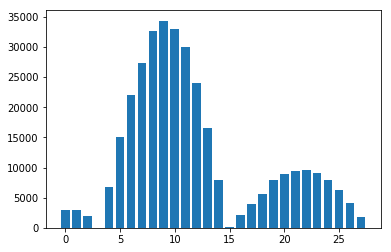

In [42]:
plt.bar(np.arange(len(w[0])), w[0])

In [22]:
answ = [[2, 21, 18, 19, 22, 30, 27, 29, 28, 31, 33, 32, 34], \
        [0, 20, 24, 26, 23, 25], \
        [0, 1, 3, 6, 7, 10, 12, 15, 16, 14, 17, 13, 11],\
        [2, 4, 5, 9, 8]]

In [7]:
import sys

In [8]:
sys.path.append("../")
import utils.plot_utils as pu

In [10]:
import pickle

In [11]:
db = pickle.load(open("../../db_as_clusters", 'rb'))

In [12]:
def gen_initial_p(db, max_arr, max_per_array):
    n = len(db)
    n_arr = np.random.randint(0, max_arr)
    population = []
    for i in range(n_arr):
        n_repetitions = np.random.randint(1,max_per_array)
        arr = np.random.choice(db)
        if len(arr) > 1:
            population.extend([arr for j in range(n_repetitions)])
    
    return population

In [13]:
def population_to_pairs(pop, sp_to_n):
    pairs = {}
    for arr in pop:
        for a, b in zip(arr, arr[1:]):
            key = (sp_to_n[a], sp_to_n[b])
            if key in pairs.keys():
                pairs[key] +=1
            else:
                pairs[key] = 1
    return pairs

In [14]:
def to_graph(pairs, n):
    gr = np.zeros((n, n))

    for p, n in pairs.items():
        if p[0] >= 0 and p[1] >= 0:
            gr[int(p[0]) -1 ][int(p[1])-1] = n
    return gr

In [15]:
initial_pops = []
pcrs = []

In [16]:
from multiprocessing import Pool

In [17]:
def f(pop):
    
    #pop = gen_initial_p(db, 40, 40, i)
    
    if len(pop) > 0:
        pcr = PCR(pop, len(pop) * 100000, p = [0.1, 0.05, 0.85])
        
        gr0 = pcr.to_graph()
        
        for i in range(20):
            pcr.anneal()

        gr = pcr.to_graph()
    
    
    return (gr0, gr)
    


In [44]:
initial_pops = []
while len(initial_pops) < 1000:
    pop = gen_initial_p(db, 5, 40)
    if len(pop) > 0:
        initial_pops.append(pop)

In [423]:
len(initial_pops)

32

In [28]:
p.close()

In [29]:
p = Pool(50)

In [45]:
gr_list = []

In [46]:
for i in tqdm_notebook(range(20)):
    gr_list_ = p.map(f, initial_pops[i*50: (i+1)*50])
    gr_list.extend(gr_list_)

A Jupyter Widget

In [32]:
len(gr_list)

1000

In [42]:
pickle.dump(gr_list, open("../../data/simulation/5_20_01_005/gr_list_1000", 'wb'))

In [43]:
pickle.dump([x[0] for x in gr_list], open('../../data/simulation/5_20_01_005/before_grs', 'wb'))
pickle.dump([x[1] for x in gr_list], open('../../data/simulation/5_20_01_005/after_grs', 'wb'))

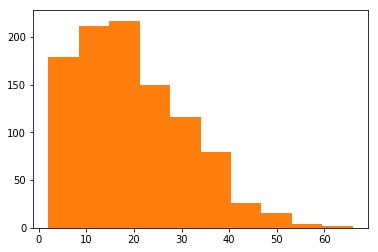

In [41]:
plt.hist([x[0].shape[0] for x in gr_list])
plt.show()

In [ ]:
np.random.set_state()

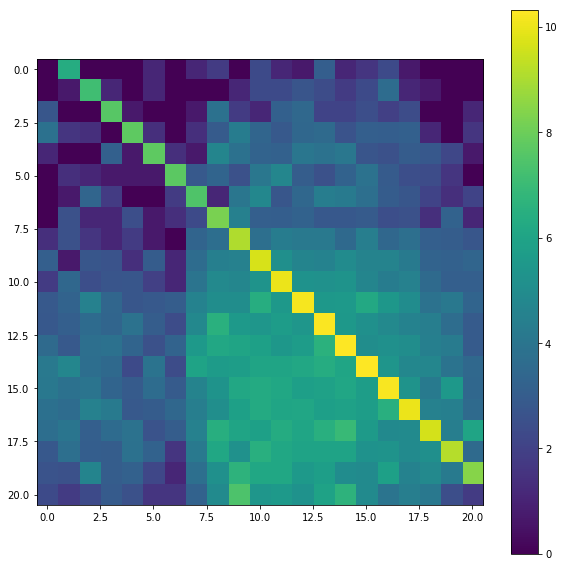

In [426]:
pu.plot_gr(gr_list[-0][1], log = 1)

In [ ]:
print(322)

In [ ]:
p.close()

In [427]:
before_grs = []
after_grs = []

In [251]:

for i in tqdm_notebook(range(1000)):
    pop = gen_initial_p(db, 40, 40)
    
    if len(pop) > 0:
        pcr = PCR(pop, len(pop) * 100000, p = [0.1, 0.05, 0.85])
        
        before_grs.append(pcr.to_graph())
        for i in range(20):
            pcr.anneal()

        after_grs.append(pcr.to_graph())

A Jupyter Widget

KeyboardInterrupt: 

In [242]:
import pickle

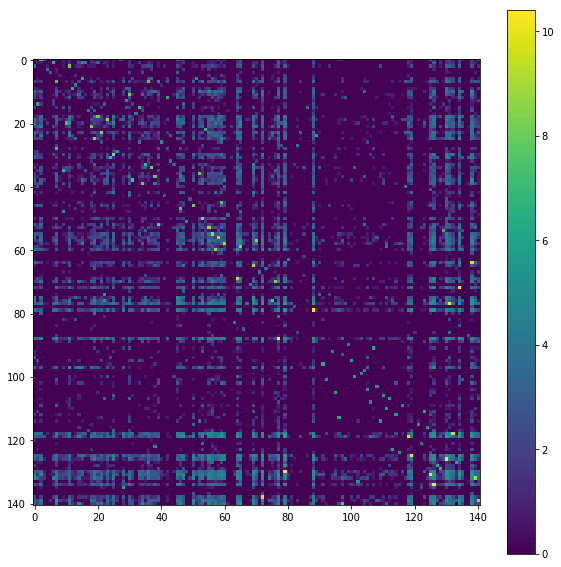

In [238]:
pu.plot_gr(after_grs[0], log = 1)


In [239]:
calc_noise_ratio(before_grs[0], after_grs[0])

0.82252584307066412

In [166]:
len(pcrs) == len(initial_pops)

True

In [167]:
before_grs = []
after_grs = []

In [168]:
for pcr, pop in tqdm_notebook(zip(pcrs, initial_pops)):
    all_spacers = set([x for y in pop for x in y])
    sp_to_n = dict(zip(all_spacers, np.arange(len(all_spacers)).astype(int)))
    
    pairs = pcr.to_pairs()
    new_pairs = {}

    for key in pairs.keys():
        new_key = (sp_to_n[key[0].astype(int)],sp_to_n[key[1].astype(int)])
        new_pairs[new_key] = pairs[key] 
        
    initial_pairs = population_to_pairs(pop, sp_to_n)
    
    before_grs.append(to_graph(initial_pairs, len(all_spacers)))
    after_grs.append(to_graph(new_pairs, len(all_spacers)))

A Jupyter Widget

KeyError: 20

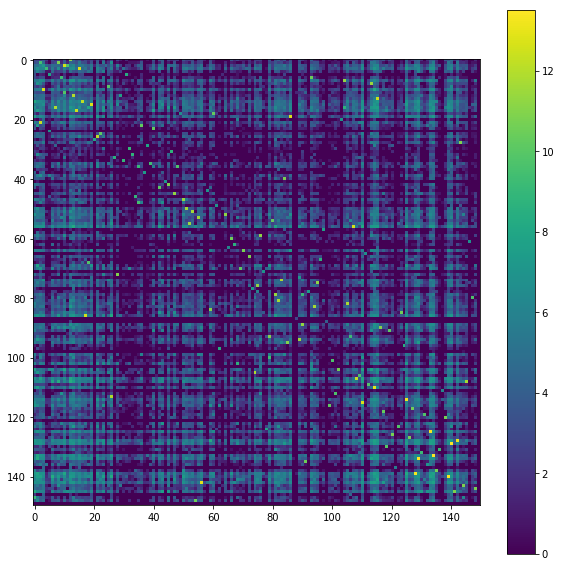

In [173]:
pu.plot_gr(after_grs[0], log = 1)